# Question 1

In this question, I am tasked to create a classifier that is able to differentiate Trump and Clinton tweets using only the text in the tweets - we are not allowed to use the location, time and any other information

In [2]:
from gensim.models.word2vec import Word2Vec
from sklearn.externals import joblib

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

/home/adityasidharta/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from tqdm import tqdm
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

In [4]:
import sys
import csv
import pandas as pd
import tweepy
import string
from string import maketrans 
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import\
TfidfVectorizer, CountVectorizer
from sklearn.model_selection import \
train_test_split, cross_val_score, KFold

In [172]:
from keras.layers import Concatenate

In [5]:
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout,\
Flatten, Input, Activation, \
Dropout, BatchNormalization, Embedding
from keras.layers import Conv1D, MaxPool1D,\
MaxPooling1D
from keras import backend as K
from keras.models import load_model
from keras import metrics

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
import nltk
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/adityasidharta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/adityasidharta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

First, I will use the package `tweepy` in python to download all of the Trump and Hillary tweets. To perform this, we need to create API key using our personal Twitter Account so that we are able to download all the tweets. For privacy reasons, I have deleted my API key.

In [8]:
ckey = "secret"
csecret = "secret"
atoken = "secret"
asecret = "secret"

In [9]:
auth = tweepy.OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)
api = tweepy.API(auth)

`Tweepy` only allows us to download 200 tweets for a single request. Thus, we will remember the oldest ID of the tweet that we have downloaded, and send multiple request until there are no more new tweets that we can download for both Trump and Hillary. We will then store the ID of the tweet, the creation time of the tweet, as well as the message of the tweet in a csv format. This is so that we can load the csv using `pandas` easily

In [10]:
def get_all_tweets(screen_name):
    alltweets = []
    new_tweets = api.user_timeline\
    (screen_name = screen_name,count=200)
    alltweets.extend(new_tweets)
    oldest = alltweets[-1].id - 1

    while len(new_tweets) > 0:
        new_tweets = api.user_timeline\
        (screen_name = screen_name,count=200,
         max_id=oldest)
        alltweets.extend(new_tweets)

        oldest = alltweets[-1].id - 1

    outtweets = [[tweet.id_str, 
                  tweet.created_at,
                  tweet.text.encode("utf-8")] \
                 for tweet in alltweets]

    with open('%s_tweets.csv' % screen_name, 
              'wb') as f:
        writer = csv.writer(f)
        writer.writerow(["id","created_at","text"])
        writer.writerows(outtweets)

pass

In [19]:
get_all_tweets('HillaryClinton')
get_all_tweets('RealDonaldTrump')

In [20]:
df_hillary = pd.read_csv('HillaryClinton_tweets.csv')
df_trump = pd.read_csv('realDonaldtrump_tweets.csv')

In [21]:
def text_process(s):
    s = str(s)
    s = s.translate(None, string.punctuation.replace('@',''))
    s = s.translate(None, '1234567890')
    s = [word for word in s.split() if not \
     (word.startswith('http') or word.startswith('@'))]
    s = ' '.join(s)
    s = re.sub(' +',' ',s)
    s = s.decode('ascii', 'ignore')
    s = s.lower()
    s = [word for word in s.split() if word not\
         in stopwords.words('english') + ['rt'] + ['amp'] + ['hillary', 'donald', 'trump' + 'u']]
    s = [wordnet_lemmatizer.lemmatize(word) for word in s]
    sentence = ' '.join(s)
    return sentence

In [22]:
df_hillary['len'] = df_hillary['text'].apply(len)
df_hillary['token'] = df_hillary['text'].apply(lambda x : text_process(x))
df_trump['len'] = df_trump['text'].apply(len)
df_trump['token'] = df_trump['text'].apply(lambda x : text_process(x))

In [23]:
df_hillary['user'] = 'hillary'
df_trump['user'] = 'trump'

In [24]:
df_hillary = df_hillary.loc[df_hillary.token != '', :]
df_trump = df_trump.loc[df_trump.token != '', :]

In [25]:
df_train = pd.concat([df_hillary, df_trump])

In [26]:
df_train

,id,created_at,text,len,token,user
0,985908580430819329,2018-04-16 15:51:37,Thinking about Barbara Bush’s legacy of servic...,144,thinking barbara bush legacy service country e...,hillary
1,984611815798820864,2018-04-13 01:58:44,More terrific work from a group of progressive...,139,terrific work group progressive working turn a...,hillary
2,984597321353715712,2018-04-13 01:01:09,Storytelling is at the heart of every cultural...,145,storytelling heart every cultural political re...,hillary
3,983464202919653376,2018-04-09 21:58:32,Congratulations Tammy! https://t.co/H85PIeycUm,46,congratulation tammy,hillary
4,981716478218133504,2018-04-05 02:13:42,"Rev. Dr. Martin Luther King, Jr was in Memphis...",142,rev dr martin luther king jr memphis protest s...,hillary
5,981709339294650369,2018-04-05 01:45:20,Thanks for the warm welcome last night! Inspir...,104,thanks warm welcome last night inspired passio...,hillary
6,981664484120039424,2018-04-04 22:47:06,"Wishing @JuliaGillard, Former Aussie PM, the b...",146,wishing former aussie pm best today launch new...,hillary
7,979823851222786048,2018-03-30 20:53:05,A little over 15 years ago a bright young woma...,142,little year ago bright young woman walked offi...,hillary
8,979823364113141763,2018-03-30 20:51:08,We are indeed on the brink. Thank you to Rutge...,142,indeed brink thank rutgers yesterday student c...,hillary
9,977616710588141568,2018-03-24 18:42:41,Listening to the students from Parkland and ac...,142,listening student parkland across country toda...,hillary


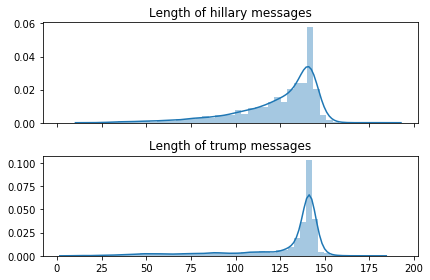

In [27]:
length_hillary = df_train[df_train['user'] == 'hillary'].len.values
length_trump = df_train[df_train['user'] == 'trump'].len.values
fig, axes = plt.subplots(nrows = 2, sharex= True)
sns.distplot(length_hillary, ax= axes[0]).\
set_title('Length of hillary messages')
sns.distplot(length_trump, ax = axes[1]).\
set_title('Length of trump messages')
plt.tight_layout()
plt.show()

In [28]:
hillary_words =  ''
trump_words = ''
array_label = df_train['user'].values
df_messages = df_train['token'].values

for idx in range(len(df_messages)):
    if array_label[idx] == 'hillary':
        hillary_words += '' + str(df_messages[idx])
    else:
        trump_words += '' + str(df_messages[idx])

In [29]:
from wordcloud import WordCloud
hillary_wordcloud = WordCloud(width=600, height=400).generate(hillary_words)
trump_wordcloud = WordCloud(width=600, height=400).generate(trump_words)

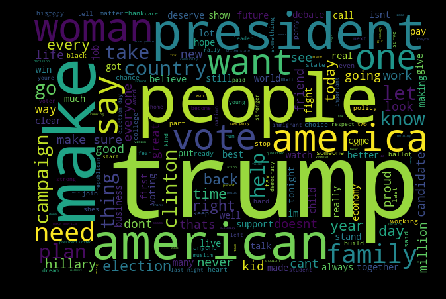

In [30]:
plt.figure( figsize=(6,5), facecolor='k')
plt.imshow(hillary_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

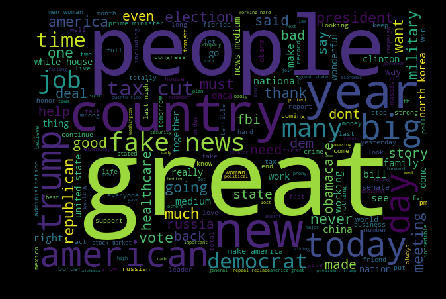

In [31]:
plt.figure( figsize=(6,5), facecolor='k')
plt.imshow(trump_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [32]:
Y_train = np.where(df_train.user == 'hillary', 1, 0)
message = df_train.token.values

In [33]:
kfold = KFold(n_splits = 5, shuffle = True, random_state=1234)

In [34]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score

# Count

In [209]:
count_vectorizer = CountVectorizer()
X_train = count_vectorizer.fit_transform(message)

In [210]:
print Y_train.shape
print X_train.shape

(6426,)
(6426, 8533)


In [211]:
log_count_model = LogisticRegressionCV()
log_count_score = cross_val_score(log_count_model,
                                  X_train, Y_train,
                                  scoring = 'accuracy',
                                  cv = kfold.split(X_train),
                                  n_jobs=-1).mean()
print log_count_score

0.8865540299302272


In [212]:
svc_count_model = LinearSVC()
svc_count_score = cross_val_score(svc_count_model,
                                  X_train, Y_train,
                                  scoring = 'accuracy',
                                  cv = kfold.split(X_train),
                                  n_jobs=-1).mean()
print svc_count_score

0.8706802379410714


In [213]:
nb_count_model = MultinomialNB()
nb_count_score = cross_val_score(nb_count_model, 
                                 X_train, Y_train,
                                 scoring = 'accuracy', 
                                 cv = kfold.split(X_train,),
                                 n_jobs=-1).mean()
print nb_count_score

0.9067848303489843


In [214]:
gb_count_model = GradientBoostingClassifier()
gb_count_score = cross_val_score(gb_count_model, 
                                 X_train, Y_train,
                                 scoring = 'accuracy', 
                                 cv = kfold.split(X_train),
                                 n_jobs=-1).mean()
print gb_count_score

0.7765355731584075


In [215]:
rf_count_model = RandomForestClassifier()
rf_count_score = cross_val_score(rf_count_model, 
                                 X_train, Y_train,
                                 scoring = 'accuracy', 
                                 cv = kfold.split(X_train),
                                 n_jobs=-1).mean()
print rf_count_score

0.8454716764195073


# TF-IDF

In [192]:
tfidf_vectorizer = TfidfVectorizer("english")
X_train = tfidf_vectorizer.fit_transform(message)

In [193]:
log_tfidf_model = LogisticRegressionCV()
log_tfidf_score = cross_val_score(log_tfidf_model,
                                  X_train, Y_train,
                                  scoring = 'accuracy',
                                  cv = kfold.split(X_train),
                                  n_jobs=-1).mean()
print log_tfidf_score

0.8944904418127576


In [194]:
svc_tfidf_model = LinearSVC()
svc_tfidf_score = cross_val_score(svc_tfidf_model,
                                  X_train, Y_train,
                                  scoring = 'accuracy',
                                  cv = kfold.split(X_train),
                                  n_jobs=-1).mean()
print svc_count_score

0.8916900956726435


In [195]:
nb_tfidf_model = MultinomialNB()
nb_tfidf_score = cross_val_score(nb_tfidf_model, 
                                 X_train, Y_train,
                                 scoring = 'accuracy', 
                                 cv = kfold.split(X_train,),
                                 n_jobs=-1).mean()
print nb_tfidf_score

0.9018048907419622


In [196]:
gb_tfidf_model = GradientBoostingClassifier()
gb_tfidf_score = cross_val_score(gb_tfidf_model, 
                                 X_train, Y_train,
                                 scoring = 'accuracy', 
                                 cv = kfold.split(X_train),
                                 n_jobs=-1).mean()
print gb_tfidf_score

0.7942750119515161


In [197]:
rf_tfidf_model = RandomForestClassifier()
rf_tfidf_score = cross_val_score(rf_tfidf_model, 
                                 X_train, Y_train,
                                 scoring = 'accuracy', 
                                 cv = kfold.split(X_train),
                                 n_jobs=-1).mean()
print rf_tfidf_score

0.8423590780086052


# Word2Vec - Glove

In [56]:
def w2v_to_features(w2v, list_tokens):
    w2v_keys = w2v.keys()
    n_dims = len(w2v[w2v.keys()[0]])
    result = np.zeros((len(list_tokens), n_dims))
    for idx in tqdm(range(len(list_tokens))):
        array_features = np.array([w2v[x] 
                                   for x in 
                                   list_tokens[idx] 
                                   if x in w2v_keys])
        if len(array_features) == 0:
            continue
        else:
            result[idx] = array_features.mean(axis = 0)
    return result.astype('float64')

In [57]:
with open('glove.twitter.27B.200d.txt', "rb") as lines:
    w2v = {line.split()[0]: 
                      np.array(map(float, line.split()[1:]))
               for line in lines}

In [58]:
list_tokens = []
for idx in range(len(message)):
    list_tokens.append([str(x) for x in message[idx].split(' ')])

In [59]:
scaler = MinMaxScaler()
X_train = w2v_to_features(w2v, list_tokens)
X_train = scaler.fit_transform(X_train)

100%|██████████| 6426/6426 [1:49:43<00:00,  1.02s/it]  


In [62]:
joblib.dump(X_train, 'X_train_glove.pkl')

['X_train_glove.pkl']

In [63]:
log_glove_model = LogisticRegressionCV()
log_glove_score = cross_val_score(log_glove_model,
                                  X_train, Y_train,
                                  scoring = 'accuracy',
                                  cv = kfold.split(X_train),
                                  n_jobs=-1).mean()
print log_glove_score

0.8015846197602434


In [64]:
svc_glove_model = LinearSVC()
svc_glove_score = cross_val_score(svc_glove_model,
                                  X_train, Y_train,
                                  scoring = 'accuracy',
                                  cv = kfold.split(X_train),
                                  n_jobs=-1).mean()
print svc_glove_score

0.8015844987322316


In [65]:
nb_glove_model = MultinomialNB()
nb_glove_score = cross_val_score(nb_glove_model, 
                                 X_train, Y_train,
                                 scoring = 'accuracy', 
                                 cv = kfold.split(X_train,),
                                 n_jobs=-1).mean()
print nb_glove_score

0.7124165058002674


In [66]:
gb_glove_model = GradientBoostingClassifier()
gb_glove_score = cross_val_score(gb_glove_model, 
                                 X_train, Y_train,
                                 scoring = 'accuracy', 
                                 cv = kfold.split(X_train),
                                 n_jobs=-1).mean()
print gb_glove_score

0.8028303610870736


In [67]:
rf_glove_model = RandomForestClassifier()
rf_glove_score = cross_val_score(rf_glove_model, 
                                 X_train, Y_train,
                                 scoring = 'accuracy', 
                                 cv = kfold.split(X_train),
                                 n_jobs=-1).mean()
print rf_glove_score

0.7262708243823033


# Embedding - Dense

In [68]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(message)
sequences = tokenizer.texts_to_sequences(message)

In [69]:
length = []
for x in sequences:
    length.extend(x)
max(length)

8554

In [70]:
X_train = pad_sequences(sequences, maxlen=21)
X_train.shape

(6426, 21)

In [105]:
inputs = Input(shape=(21,))
X = Embedding(input_dim = 8555, output_dim = 100, input_length=21)(inputs)
X = Flatten()(X)
X = Dense(100, activation='tanh')(X)
X = BatchNormalization()(X)
X = Dropout(0.05)(X)
X = Dense(1, activation='sigmoid')(X)

FCN_model = Model(inputs, X, name='FCN_model')
FCN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
FCN_model.summary()
FCN_model.save_weights('FCN_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 21)                0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 21, 100)           855500    
_________________________________________________________________
flatten_13 (Flatten)         (None, 2100)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               210100    
_________________________________________________________________
batch_normalization_20 (Batc (None, 100)               400       
_________________________________________________________________
dropout_15 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 101       
Total para

In [106]:
kfold_score = []
for fit_index, val_index in kfold.split(X_train):
    FCN_model.load_weights('FCN_model.h5')
    X_fit, X_val = X_train[fit_index], X_train[val_index]
    Y_fit, Y_val = Y_train[fit_index], Y_train[val_index]
    FCN_model.fit(X_fit, Y_fit, batch_size=32, epochs = 3)
    Y_val_pred = FCN_model.predict(X_val, batch_size=32).reshape(-1)
    Y_val_pred = np.where(Y_val_pred >= 0.50, 1, 0)
    kfold_score.append(accuracy_score(Y_val, Y_val_pred))

Epoch 1/3
5140/5140 [==============================] - 4s 806us/step - loss: 0.4739 - acc: 0.7819
Epoch 2/3
5140/5140 [==============================] - 2s 458us/step - loss: 0.0930 - acc: 0.9652
Epoch 3/3
5140/5140 [==============================] - 2s 459us/step - loss: 0.0354 - acc: 0.9889
Epoch 1/3
5141/5141 [==============================] - 2s 456us/step - loss: 0.4691 - acc: 0.7919
Epoch 2/3
5141/5141 [==============================] - 2s 464us/step - loss: 0.0958 - acc: 0.9642
Epoch 3/3
5141/5141 [==============================] - 2s 461us/step - loss: 0.0318 - acc: 0.9907
Epoch 1/3
5141/5141 [==============================] - 2s 473us/step - loss: 0.4581 - acc: 0.7977
Epoch 2/3
5141/5141 [==============================] - 2s 461us/step - loss: 0.0879 - acc: 0.9708
Epoch 3/3
5141/5141 [==============================] - 2s 463us/step - loss: 0.0290 - acc: 0.9926
Epoch 1/3
5141/5141 [==============================] - 2s 472us/step - loss: 0.4833 - acc: 0.7919
Epoch 2/3
5141/5141 

In [107]:
FCN_score = np.mean(kfold_score)
FCN_score

0.8747299562483736

# Embedding - Conv

In [165]:
inputs = Input(shape=(21,), name = 'Input')
X = Embedding(input_dim = 8555, output_dim = 100, input_length=21, name = 'Embedding')(inputs)
X = Conv1D(100, kernel_size=2, padding='valid', activation='tanh', strides=1, name = 'Conv1')(X)
X = BatchNormalization(name = 'BN1')(X)
X = Dropout(0.10, name = 'Drop1')(X)
X = MaxPool1D(2, 2, name = 'MaxPool1')(X)

X = Conv1D(100, kernel_size=2, padding='same', activation='tanh', strides=1, name = 'Conv2')(X)
X = BatchNormalization(name = 'BN2')(X)
X = Dropout(0.10, name = 'Drop2')(X)
X = MaxPool1D(2, 2, name = 'MaxPool1')(X)

X = Flatten()(X)
X = Dense(100, activation='tanh', name = '')(X)
X = BatchNormalization()(X)
X = Dense(1, activation='sigmoid')(X)

CCN_model = Model(inputs, X, name='CCN_model')
CCN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
CCN_model.summary()
CCN_model.save_weights('CCN_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 21)                0         
_________________________________________________________________
embedding_33 (Embedding)     (None, 21, 100)           855500    
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 20, 100)           20100     
_________________________________________________________________
batch_normalization_76 (Batc (None, 20, 100)           400       
_________________________________________________________________
dropout_49 (Dropout)         (None, 20, 100)           0         
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 10, 100)           0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 10, 100)           20100     
__________

In [166]:
kfold_score = []
for fit_index, val_index in kfold.split(X_train):
    CCN_model.load_weights('CCN_model.h5')
    X_fit, X_val = X_train[fit_index], X_train[val_index]
    Y_fit, Y_val = Y_train[fit_index], Y_train[val_index]
    CCN_model.fit(X_fit, Y_fit, batch_size=32, epochs = 3)
    Y_val_pred = CCN_model.predict(X_val, batch_size=32).reshape(-1)
    Y_val_pred = np.where(Y_val_pred >= 0.50, 1, 0)
    kfold_score.append(accuracy_score(Y_val, Y_val_pred))

Epoch 1/3
5140/5140 [==============================] - 7s 1ms/step - loss: 0.5078 - acc: 0.7607
Epoch 2/3
5140/5140 [==============================] - 3s 568us/step - loss: 0.1330 - acc: 0.9496
Epoch 3/3
5140/5140 [==============================] - 3s 582us/step - loss: 0.0552 - acc: 0.9794
Epoch 1/3
5141/5141 [==============================] - 3s 571us/step - loss: 0.4747 - acc: 0.7722
Epoch 2/3
5141/5141 [==============================] - 3s 579us/step - loss: 0.1072 - acc: 0.9590
Epoch 3/3
5141/5141 [==============================] - 3s 596us/step - loss: 0.0416 - acc: 0.9862
Epoch 1/3
5141/5141 [==============================] - 3s 587us/step - loss: 0.4601 - acc: 0.7893
Epoch 2/3
5141/5141 [==============================] - 3s 570us/step - loss: 0.1140 - acc: 0.9593
Epoch 3/3
5141/5141 [==============================] - 3s 580us/step - loss: 0.0387 - acc: 0.9887
Epoch 1/3
5141/5141 [==============================] - 3s 587us/step - loss: 0.4645 - acc: 0.7874
Epoch 2/3
5141/5141 [=

In [167]:
CCN_score = np.mean(kfold_score)
CCN_score

0.8755051406648068

# Embedding - Inception-CNN

In [189]:
inputs = Input(shape=(21,))

X = Embedding(input_dim = 8555, output_dim = 100, input_length=21)(inputs)

bigram = Conv1D(50, kernel_size=2, padding='same', activation='tanh', strides=1)(X)
bigram = BatchNormalization()(bigram)
bigram = Dropout(0.10)(bigram)
bigram = MaxPooling1D(2, 2)(bigram)

trigram = Conv1D(30, kernel_size=3, padding='same', activation='tanh', strides=1)(X)
trigram = BatchNormalization()(trigram)
trigram = Dropout(0.10)(trigram)
trigram = MaxPooling1D(2, 2)(trigram)

quadgram = Conv1D(20, kernel_size=4, padding='same', activation='tanh', strides=1)(X)
quadgram = BatchNormalization()(quadgram)
quadgram = Dropout(0.10)(quadgram)
quadgram = MaxPooling1D(2, 2)(quadgram)

X = Concatenate(axis=-1)([bigram, trigram, quadgram])
X = Flatten()(X)
X = Dense(200, activation='tanh')(X)
X = BatchNormalization()(X)
X = Dense(1, activation='sigmoid')(X)

Incep_CCN_model = Model(inputs, X, name='Incep_CCN_model')
Incep_CCN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
Incep_CCN_model.summary()
Incep_CCN_model.save_weights('Incep_CCN_model.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           (None, 21)           0                                            
__________________________________________________________________________________________________
embedding_45 (Embedding)        (None, 21, 100)      855500      input_45[0][0]                   
__________________________________________________________________________________________________
conv1d_67 (Conv1D)              (None, 21, 50)       10050       embedding_45[0][0]               
__________________________________________________________________________________________________
conv1d_68 (Conv1D)              (None, 21, 30)       9030        embedding_45[0][0]               
__________________________________________________________________________________________________
conv1d_69 

In [190]:
kfold_score = []
for fit_index, val_index in kfold.split(X_train):
    Incep_CCN_model.load_weights('Incep_CCN_model.h5')
    X_fit, X_val = X_train[fit_index], X_train[val_index]
    Y_fit, Y_val = Y_train[fit_index], Y_train[val_index]
    Incep_CCN_model.fit(X_fit, Y_fit, batch_size=32, epochs = 3)
    Y_val_pred = Incep_CCN_model.predict(X_val, batch_size=32).reshape(-1)
    Y_val_pred = np.where(Y_val_pred >= 0.50, 1, 0)
    kfold_score.append(accuracy_score(Y_val, Y_val_pred))

Epoch 1/3
5140/5140 [==============================] - 9s 2ms/step - loss: 0.4986 - acc: 0.7739
Epoch 2/3
5140/5140 [==============================] - 3s 592us/step - loss: 0.0935 - acc: 0.9665
Epoch 3/3
5140/5140 [==============================] - 3s 590us/step - loss: 0.0357 - acc: 0.9875
Epoch 1/3
5141/5141 [==============================] - 3s 663us/step - loss: 0.4747 - acc: 0.7973
Epoch 2/3
5141/5141 [==============================] - 3s 589us/step - loss: 0.0926 - acc: 0.9667
Epoch 3/3
5141/5141 [==============================] - 3s 599us/step - loss: 0.0310 - acc: 0.9911
Epoch 1/3
5141/5141 [==============================] - 3s 594us/step - loss: 0.4549 - acc: 0.7991
Epoch 2/3
5141/5141 [==============================] - 3s 596us/step - loss: 0.0780 - acc: 0.9714
Epoch 3/3
5141/5141 [==============================] - 3s 591us/step - loss: 0.0296 - acc: 0.9918
Epoch 1/3
5141/5141 [==============================] - 3s 602us/step - loss: 0.4677 - acc: 0.7960
Epoch 2/3
5141/5141 [=

In [191]:
Incep_CCN_score = np.mean(kfold_score)
Incep_CCN_score

0.879551228131751

In [218]:
result = {
    'label' : ['log_count_score' , 'svc_count_score',
               'nb_count_score', 'gb_count_score',
              'rf_count_score', 'log_tfidf_score',
              'svc_tfidf_score', 'nb_tfidf_score',
              'gb_tfidf_score', 'rf_tfidf_score',
              'log_glove_score', 'svc_glove_score',
              'nb_glove_score', 'gb_glove_score',
              'rf_glove_score', 'FCN_score',
              'CCN_score', 'Incep_CCN_score'],
    'score' : [log_count_score , svc_count_score,
               nb_count_score, gb_count_score,
              rf_count_score, log_tfidf_score,
              svc_tfidf_score, nb_tfidf_score,
              gb_tfidf_score, rf_tfidf_score,
              log_glove_score, svc_glove_score,
              nb_glove_score, gb_glove_score,
              rf_glove_score, FCN_score,
              CCN_score, Incep_CCN_score]
}

df_result = pd.DataFrame(result)
display(df_result.sort_values('score', ascending=False))

,label,score
2,nb_count_score,0.906785
7,nb_tfidf_score,0.901805
5,log_tfidf_score,0.894490
6,svc_tfidf_score,0.891690
0,log_count_score,0.886554
17,Incep_CCN_score,0.879551
16,CCN_score,0.875505
15,FCN_score,0.874730
1,svc_count_score,0.870680
4,rf_count_score,0.845472


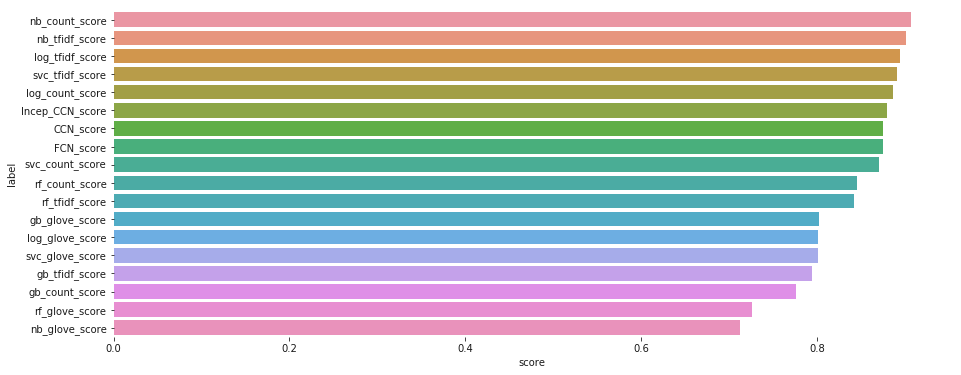

In [219]:
import seaborn as sns
df_result = df_result.sort_values('score', ascending=False)
f, ax = plt.subplots(figsize=(15, 6))
sns.set_color_codes("pastel")
ax = sns.barplot(x='score', y='label', data=df_result, orient='h')
sns.despine(left=True, bottom=True)

In [236]:
final_model = MultinomialNB().fit(X_train, Y_train)

In [263]:
from IPython.display import Image 

def TrumporClinton(tweet):
    processed_tweet =  text_process(tweet)
    X_test = count_vectorizer.transform(np.array([processed_tweet]))
    if final_model.predict(X_test)[0] == 0:
        return Image(filename='trump.jpg', width = 100, height =70)
    else:
        return Image(filename='hillary.jpeg', width = 100, height =70)

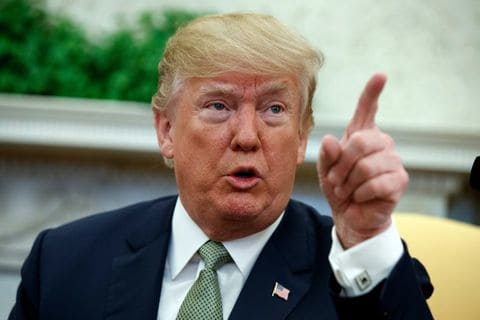

In [275]:
TrumporClinton("We are going to build a wall and Mexico is going to pay for it!")

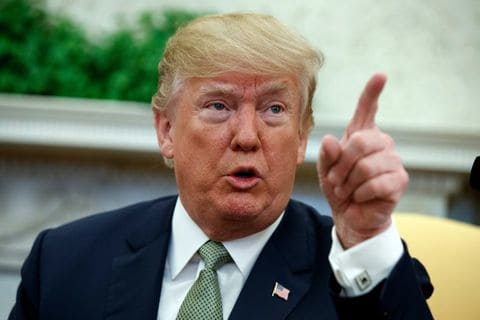

In [277]:
TrumporClinton('Make America Great Again! China is Stealing our Job!')

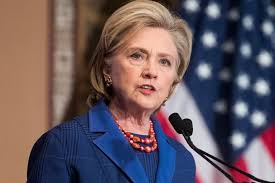

In [280]:
TrumporClinton("We cannot allow Trump to be president. This man is dangerous.")

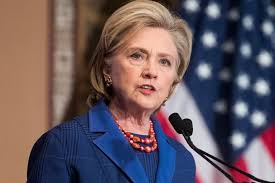

In [292]:
TrumporClinton("Gay rights are human rights.")

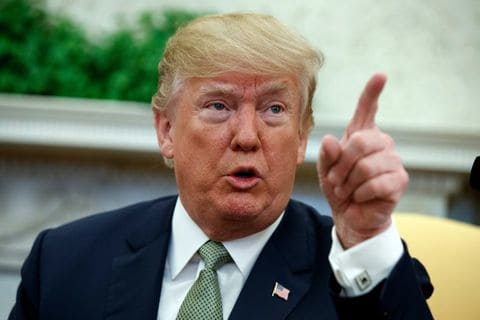

In [293]:
TrumporClinton('Slippery James Comey, the worst FBI Director in history, was not fired because of the phony Russia investigation where, by the way, there was NO COLLUSION (except by the Dems)!')

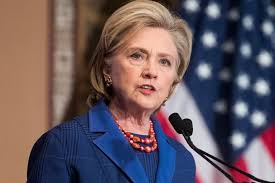

In [274]:
TrumporClinton('Thinking about Barbara Bush’s legacy of service to our country and the extraordinary family she raised. Thanking her for her many kindnesses to me and my family. Wishing her the comfort she deserves surrounded by her loved ones.')